# Installs & Imports

In [1]:
!pip install -q xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import pickle
import os
import sys

from scipy.stats import uniform, randint

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import plotly.express as px

from xgboost import XGBClassifier

# Loading the Data

In [4]:
# Load the data
file_path = "/content/StudentsPerformance.csv"

df = pd.read_csv(file_path)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
# Rename columns
df.columns = ['gender', 'race_ethnicity', 'parental_education_level', 'lunch', 'test_prep_course', 'math_score', 'reading_score', 'writing_score']
df.head()

,gender,race_ethnicity,parental_education_level,lunch,test_prep_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# Exploring the Data

In [6]:
# Inspect the data
print(f"Data Shape: {df.shape}")
df.info()

Data Shape: (1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    1000 non-null   object
 1   race_ethnicity            1000 non-null   object
 2   parental_education_level  1000 non-null   object
 3   lunch                     1000 non-null   object
 4   test_prep_course          1000 non-null   object
 5   math_score                1000 non-null   int64 
 6   reading_score             1000 non-null   int64 
 7   writing_score             1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [7]:
# Convert object dtypes to categorical dtypes
df = df.astype({col: 'category' for col in df.select_dtypes(include=['object']).columns})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   gender                    1000 non-null   category
 1   race_ethnicity            1000 non-null   category
 2   parental_education_level  1000 non-null   category
 3   lunch                     1000 non-null   category
 4   test_prep_course          1000 non-null   category
 5   math_score                1000 non-null   int64   
 6   reading_score             1000 non-null   int64   
 7   writing_score             1000 non-null   int64   
dtypes: category(5), int64(3)
memory usage: 29.2 KB


In [8]:
# Get value counts for each group
df['race_ethnicity'].value_counts()

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race_ethnicity, dtype: int64

In [9]:
# Get value counts for the features
for col in df.select_dtypes(include=['category']).columns:
    print(f"\n{col}:\n{df[col].value_counts()}")


gender:
female    518
male      482
Name: gender, dtype: int64

race_ethnicity:
group C    319
group D    262
group B    190
group E    140
group A     89
Name: race_ethnicity, dtype: int64

parental_education_level:
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental_education_level, dtype: int64

lunch:
standard        645
free/reduced    355
Name: lunch, dtype: int64

test_prep_course:
none         642
completed    358
Name: test_prep_course, dtype: int64


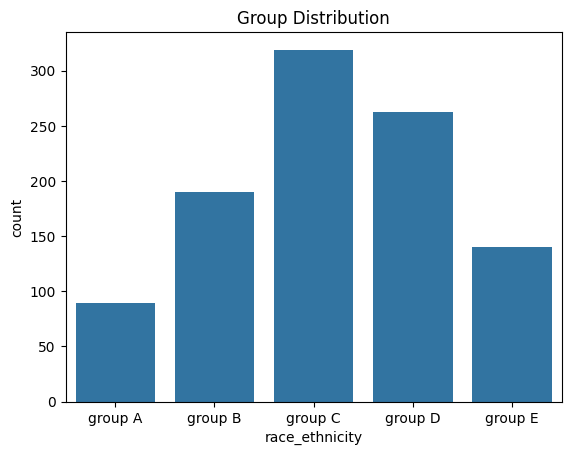

In [10]:
# Plot the group distribution
sns.countplot(x='race_ethnicity', data=df)
plt.title('Group Distribution')
plt.show()

In [11]:
# Descriptive statistics for each group
grouped = df.groupby('race_ethnicity').describe().round(2)
eths = ['group A', 'group B', 'group C', 'group D', 'group E']
for eth in eths:
    if eth in grouped.index:
        print(f"{eth}:")
        print(f"{grouped.loc[eth]}\n")
    else:
        print(f"{eth} not found in the DataFrame")

group A:
math_score     count     89.00
               mean      61.63
               std       14.52
               min       28.00
               25%       51.00
               50%       61.00
               75%       71.00
               max      100.00
reading_score  count     89.00
               mean      64.67
               std       15.54
               min       23.00
               25%       53.00
               50%       64.00
               75%       74.00
               max      100.00
writing_score  count     89.00
               mean      62.67
               std       15.47
               min       19.00
               25%       51.00
               50%       62.00
               75%       73.00
               max       97.00
Name: group A, dtype: float64

group B:
math_score     count    190.00
               mean      63.45
               std       15.47
               min        8.00
               25%       54.00
               50%       63.00
               75%   

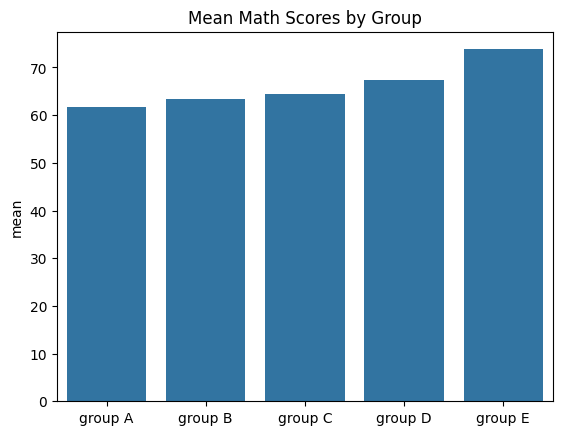

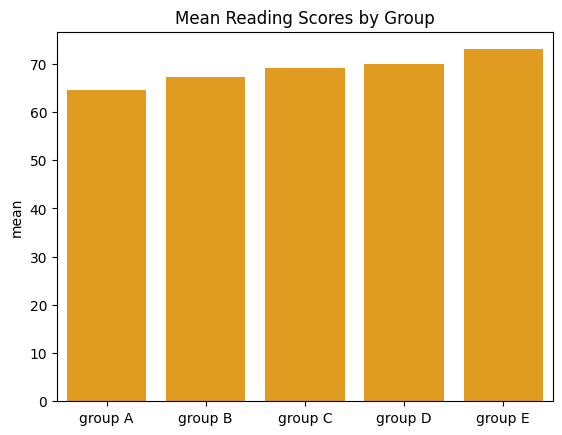

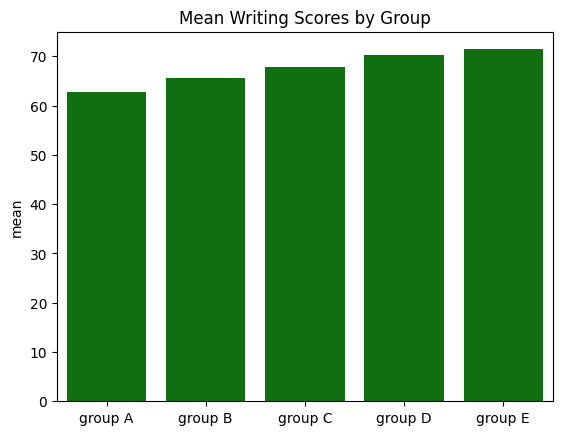

In [12]:
# Plot the mean scores for each group
sns.barplot(x=eths, y=grouped.loc[eths, 'math_score']['mean'])
plt.title('Mean Math Scores by Group')
plt.show()

sns.barplot(x=eths, y=grouped.loc[eths, 'reading_score']['mean'], color='orange')
plt.title('Mean Reading Scores by Group')
plt.show()

sns.barplot(x=eths, y=grouped.loc[eths, 'writing_score']['mean'], color='green')
plt.title('Mean Writing Scores by Group')
plt.show()

In [13]:
# Create correlation matrix
corr = df.corr(numeric_only=True).round(2)
corr

,math_score,reading_score,writing_score
math_score,1.00,0.82,0.80
reading_score,0.82,1.00,0.95
writing_score,0.80,0.95,1.00


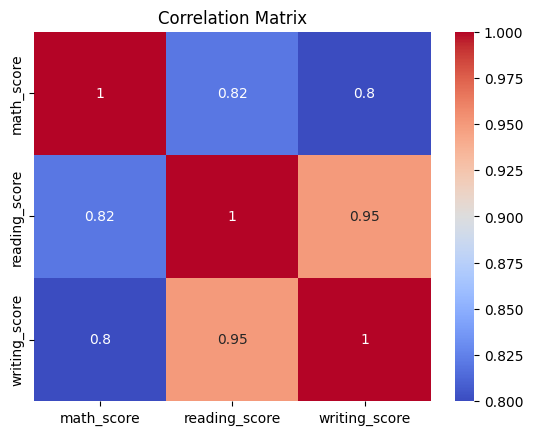

In [14]:
# Create heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [15]:
# Pivot table of scores by gender and ethnicity
df_copy = df.copy()
pivot = df_copy.pivot_table(index='gender', columns='race_ethnicity', values=['math_score', 'reading_score', 'writing_score'], aggfunc='mean').round(2)
pivot.T

gender                        female   male
              race_ethnicity               
math_score    group A          58.53  63.74
              group B          61.40  65.93
              group C          62.03  67.61
              group D          65.25  69.41
              group E          70.81  76.75
reading_score group A          69.00  61.74
              group B          71.08  62.85
              group C          71.94  65.42
              group D          74.05  66.14
              group E          75.84  70.30
writing_score group A          67.86  59.15
              group B          70.05  60.22
              group C          71.78  62.71
              group D          75.02  65.41
              group E          75.54  67.39

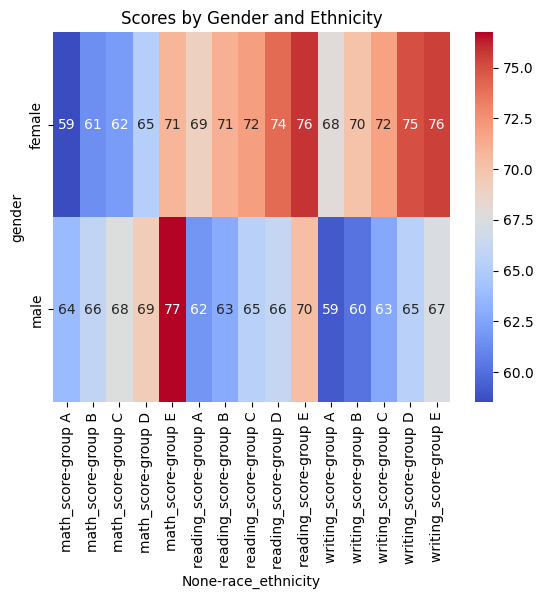

In [16]:
# Plot the pivot table
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Scores by Gender and Ethnicity')
plt.show()

# Preprocessing the Data

## Splitting the Data

In [17]:
# Define features and labels
X = df[[col for col in df.columns if col != 'race_ethnicity']]
y = df['race_ethnicity']

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}\n")

print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (800, 7)
y_train Shape: (800,)

X_test Shape: (200, 7)
y_test Shape: (200,)


## Creating a Pipeline

In [19]:
# Encode the labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [20]:
# Define each feature type
numeric_features = ['math_score', 'reading_score', 'writing_score']
binary_features = ['gender', 'lunch', 'test_prep_course']
categorical_features = ['parental_education_level']

# Define the preprocessing steps
numeric_transformer = Pipeline(
    steps=[
        ('poly_features', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler())
    ]
)
binary_transformer = OrdinalEncoder()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the feature selector
feature_selector = RFECV(
    estimator=RandomForestClassifier(),
    step=1,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy'
)

# Define the pipeline
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('classifier', XGBClassifier())
    ]
)

# Training with Cross Validation

In [21]:
# Perform 5-fold stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=5)
scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold)

# Print the accuracy for each fold
print(f"Accuracy for each fold: {scores}")

# Print the mean accuracy and the standard deviation
print(f"Mean accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")

Accuracy for each fold: [0.3     0.2625  0.24375 0.26875 0.24375]
Mean accuracy: 0.26375
Standard deviation: 0.020691181696558557


# Hyperparameter Tuning

In [22]:
# Define the search grid
param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__learning_rate': uniform(0.01, 0.6),
    'classifier__subsample': uniform(0.3, 0.6),
    'classifier__max_depth': randint(3, 10),
    'classifier__colsample_bytree': uniform(0.5, 0.45),
    'classifier__min_child_weight': randint(1, 6)
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=stratified_kfold,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best score and best hyperparameters
print(f"Best score: {random_search.best_score_}")
print(f"Best hyperparameters: {random_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.275
Best hyperparameters: {'classifier__colsample_bytree': 0.6905306663178663, 'classifier__learning_rate': 0.24692891090534183, 'classifier__max_depth': 9, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 598, 'classifier__subsample': 0.7241144063085703}


In [23]:
# Extract the best hyperparameters
best_params = random_search.best_params_
best_classifier_params = {key.replace('classifier__', ''): value for key, value in best_params.items() if 'classifier__' in key}

# Define the new pipeline
best_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('classifier', XGBClassifier(**best_classifier_params))
    ]
)

# Fit the pipeline
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['math_score',
                                                   'reading_score',
                                                   'writing_score']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['gender', 'lunch',
                                                   'test_prep_course']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['parental_educatio...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.24692891090534183, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=598, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

# Test Set Evaluation

In [24]:
# Make predictions on the test set
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.28


In [25]:
# Create DataFrame for metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr'),
    'log_loss': log_loss(y_test, y_pred_proba)
}

# Print the metrics
metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df = metrics_df.T
metrics_df.index.name = 'Metrics'
metrics_df.columns = ['Scores']

metrics_df

,Scores
Metrics,
accuracy,0.280000
precision,0.224337
recall,0.241272
f1,0.231435
roc_auc,0.553531
log_loss,2.728320


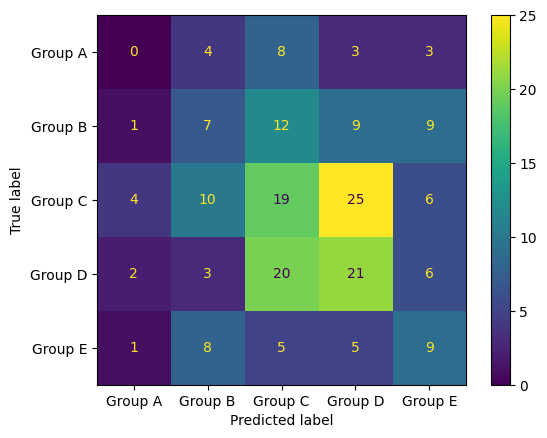

In [26]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
label_mapping = {
    0: 'Group A',
    1: 'Group B',
    2: 'Group C',
    3: 'Group D',
    4: 'Group E'
}
display_labels = [label_mapping[label] for label in unique_labels]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the confusion matrix
disp.plot()
plt.show()

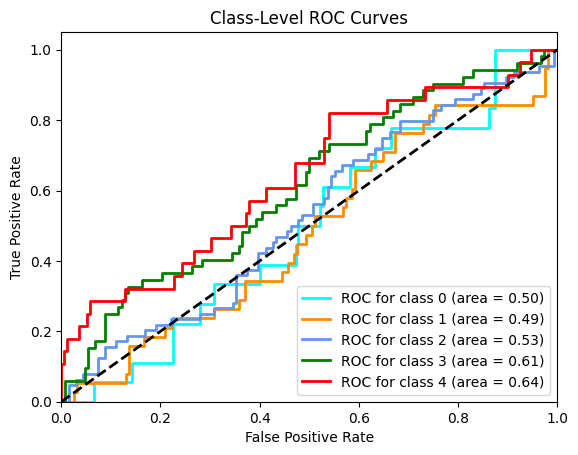

In [27]:
# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]
lw = 2

# Compute ROC curve and ROC area for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i], lw=lw,
             label='ROC for class {0} (area = {1:0.2f})'.format(i, roc_auc))

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class-Level ROC Curves')
plt.legend(loc="lower right")
plt.show()

Number of features before selection: 18
Number of features after selection: 16
Removed features (2): cat__parental_education_level_bachelor's degree, cat__parental_education_level_master's degree


,Feature,Importance
8,num__writing_score^2,0.074538
13,cat__parental_education_level_high school,0.069732
12,cat__parental_education_level_associate's degree,0.068473
1,num__reading_score,0.066706
15,cat__parental_education_level_some high school,0.066519
4,num__math_score reading_score,0.065961
14,cat__parental_education_level_some college,0.065278
2,num__writing_score,0.064389
7,num__reading_score writing_score,0.063168
3,num__math_score^2,0.062574


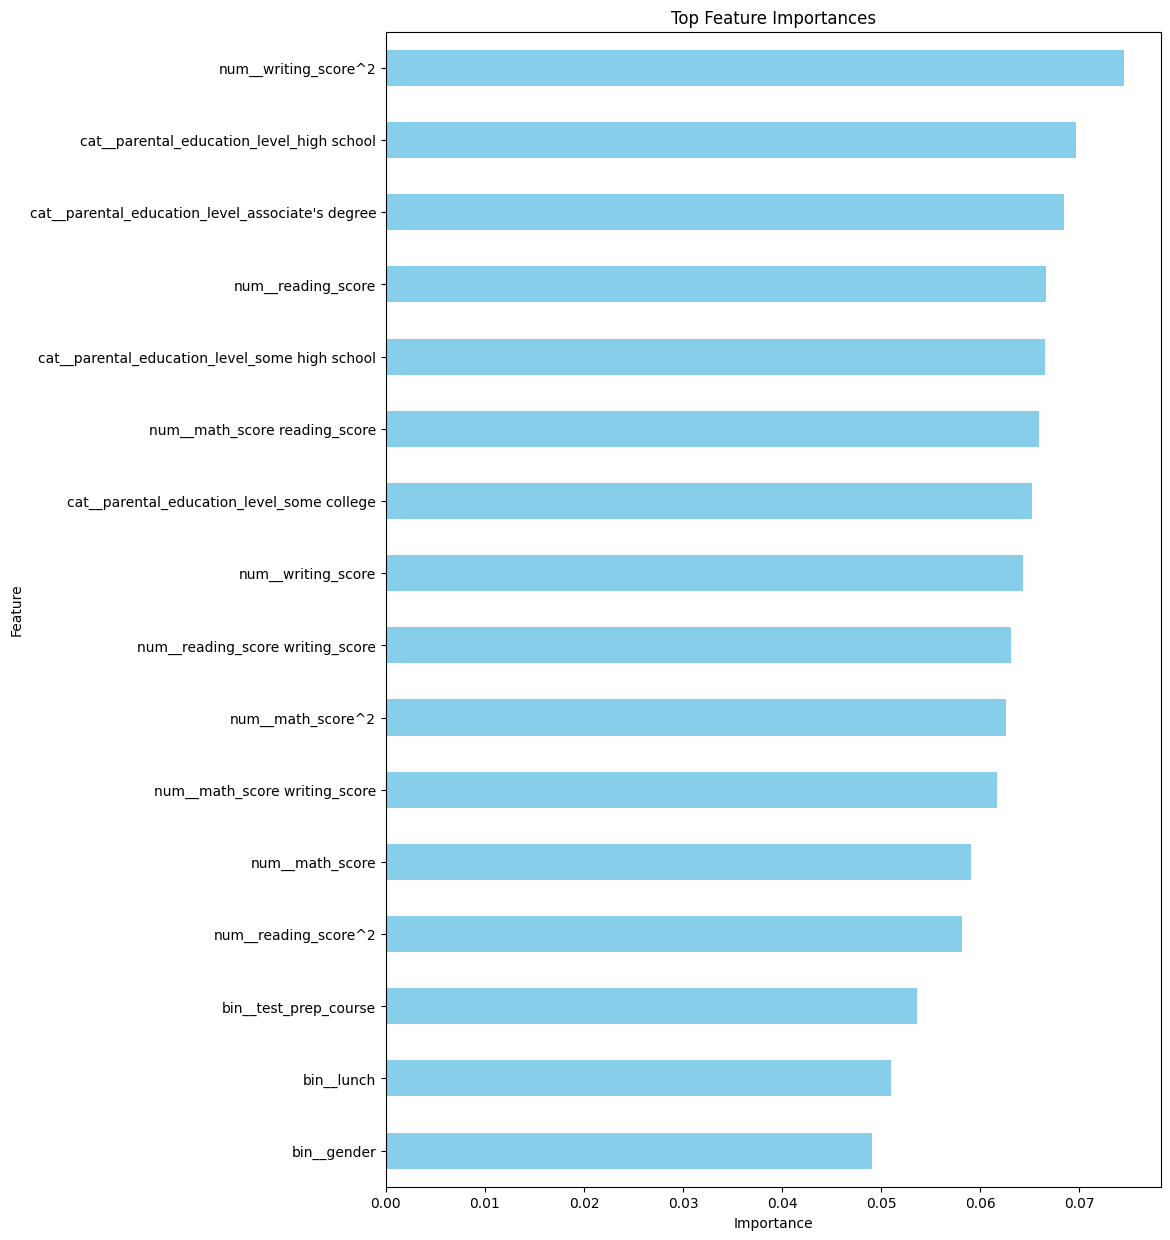

In [28]:
# Function to extract feature names and importances
def extract_features_and_importances(pipeline):
    # Get the feature names after preprocessing
    preprocessed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    num_features_before_selection = len(preprocessed_feature_names)

    # Apply the feature selection mask
    support_mask = pipeline.named_steps['feature_selector'].support_
    selected_features = preprocessed_feature_names[support_mask]
    num_features_after_selection = len(selected_features)

    # Identify removed features
    removed_features = preprocessed_feature_names[~support_mask]

    # Get importances
    importances = pipeline.named_steps['classifier'].feature_importances_

    # Match the selected features with their importances
    feature_importance_dict = {feature: importance for feature, importance in zip(selected_features, importances)}

    return feature_importance_dict, num_features_before_selection, num_features_after_selection, removed_features

# Function to print DataFrame of selected features + before and after counts
def display_feature_selection_results(feature_importances, num_before, num_after, removed_features):
    # Print the counts
    print(f"Number of features before selection: {num_before}")
    print(f"Number of features after selection: {num_after}")

    # If any features were removed, print them
    if removed_features.size > 0:
        print(f"Removed features ({len(removed_features)}): {', '.join(removed_features)}")
    else:
        print("No features were removed.")

    # Convert to DataFrame for display
    importances_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

    # Display the DataFrame
    display(importances_df)

# Function to plot feature importances
def plot_feature_importances(feature_importances, top_n=20):
    # Convert to series
    importances_series = pd.Series(feature_importances).sort_values(ascending=True).tail(top_n)

    # Plot
    plt.figure(figsize=(10, top_n / 2))
    importances_series.plot(kind='barh', color='skyblue')
    plt.title('Top Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Call the functions
feature_importances, num_features_before_selection, num_features_after_selection, removed_features = extract_features_and_importances(best_pipeline)
display_feature_selection_results(feature_importances, num_features_before_selection, num_features_after_selection, removed_features)
plot_feature_importances(feature_importances, top_n=30)

In [29]:
# Save the model
model_filename = 'best_xgb_model_pipeline.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(best_pipeline, file)

print(f"Model saved to {model_filename}")

Model saved to best_xgb_model_pipeline.pkl
